# Метод k ближайших соседей

Пусть как и прежде у нас есть тренировочное множество $T^l=\{(x_i, y_i)\}_{i=1}^{l}$ и некоторая метрика на $X$: 

$$\rho: X \times X \to [0, + \infty)$$


Кроме того, пусть есть некоторое счетное семейсвто функций  $w_i: [0, +\infty) \to [0, +\infty)$, причем:
- $w_{i_1}(x) \le w_{i_2}(x)$ если $i_1 > i_2$, 
- $w_i(x_1) \le w_i(x_2)$ если $x_1 > x_2$ .

Кроме того, зададим некоторый параметр $k \in \mathbb{N}$

Будем решать задачу классификации. В общем виде алгоритм классификации будет выглядеть так:


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
from collections import defaultdict
# x- точка из X, которую нужно классифицировать
# T - тренировочное множество [(x_1, y_1), ..., (x_l, y_l)]
# dist - функтор 
def classify_knn(x, T, dist, w, k):
    """kNN классификатор

    Аргументы:
    x -- точка из X, которую нужно классифицировать
    T -- тренировочное множество [(x_1, y_1), ..., (x_l, y_l)]
    dist -- функтор, метрика в X
    w -- функтор
    k -- целое число    
    """
    accum = defaultdict(lambda: 0.)
    sorted_T = sorted([(x_, y_, dist(x, x_)) for (x_, y_) in T], key=lambda t: t[2])
    
    for i, (x_, y_, dist) in enumerate(sorted_T):
        if i >= k:
            break            
        accum[y_] += w(i + 1, dist)
    
    return max(accum.items(), key=lambda t: t[1])[0]

$k$ можно выбрать с помощью CV.

In [16]:
def gen_dataset(mean, size, clazz):    
    """Генерируем набор данных на плоскости по двумерному нормальному распределению

    Аргументы:
    mean -- мматематическое ожидание 
    size -- число точек
    clazz -- идентификатор класса
    """
    cov = np.random.random_sample(size=(2, 2))
    cov = 6 * np.dot(cov, cov.T)
    x0 = np.random.multivariate_normal(mean, cov, size)        
    return x0, clazz * np.ones(size)

In [17]:

def show_plane(x_train, y_train, classify_func):
    """Рисуем плоскость, расскашиваем её по classify_func, потому добавляем точки    
    """
    
    
    from matplotlib.colors import ListedColormap
      
    xx, yy = np.meshgrid(np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.2))
    zz = np.array([classify_func(point) for point in zip(xx.ravel(), yy.ravel())])

    plt.pcolormesh(xx, yy, zz.reshape(xx.shape), cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))

    x0 = np.array([x for x, y in zip(x_train, y_train) if y == 0])
    x1 = np.array([x for x, y in zip(x_train, y_train) if y == 1])
    
    plt.scatter(x0[:,0], x0[:, 1], c='g', marker='o')
    plt.scatter(x1[:,0], x1[:, 1], c='r', marker='x')
    plt.xlim(-9, 9)
    plt.ylim(-9, 9)
    plt.show()

In [18]:
x0, y0 = gen_dataset([-2, -2], 10, 0)
x1, y1 = gen_dataset([2, 2], 10, 1)

x_train = np.concatenate((x0, x1))
y_train = np.concatenate((y0, y1))

In [19]:
def w(i, dist):
    return 1.

def dist(x, y):
    return np.linalg.norm(x - y)

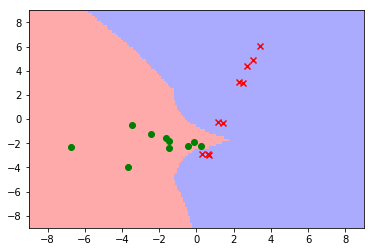

In [20]:
show_plane(x_train, y_train, lambda point : classify_knn(point, zip(x_train, y_train), dist, w, 1))

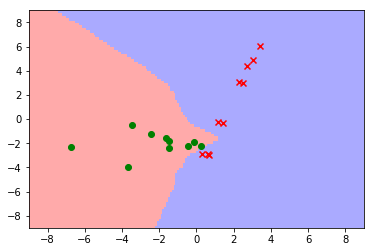

In [21]:
show_plane(x_train, y_train, lambda point : classify_knn(point, zip(x_train, y_train), dist, w, 3))    

# Оптимизация поиска ближайших соседей

Рассмотрим некоторые способы оптимизации поиска ближайших соседей к точке. При прямом подходе, когда мы вычисляем растояние от искомой точки до каждой точки из тренировочного множества, отслеживая минимальое растояние, нам нужно совершить $O(l)$ сравнений.

####  K-d Tree

Это бинарное дерево, в узлах и листьях точки из тренировочного множества. 

**Идея построения:** рассмотрим 1-ую координату всех точек, найдем медианное значение, медиана будет в корне, все что с меньшим значением идет в левое поддерево, справа - в правое. На следующем уровне рассматриваем следующую координату. На каждом узле мы делим оставшиеся области пополам. 

**Идея поиска:** с искомой точкой спускаемся по дереву, доходим до листа. Потом поднимаемся, обрабатывая все области, в которых могут быть более близкие точки.

<img src="images/Kdtree_2d.svg"/> <small>[Источник картинки](https://en.wikipedia.org/wiki/K-d_tree)</small>

В среднем требуется $O(\ln l)$ сравнений, подход не очень эффективен при больших размерностях. 

Рассмотрим простую реализацию на Python (<small>[основано на python-kdtree](https://code.google.com/p/python-kdtree)</small>):

In [9]:
class KDTreeNode(object):
    
    def __init__(self, point, left, right):
        self.point = point
        self.left = left
        self.right = right
    
    def is_leaf(self):
        return (self.left == None and self.right == None)

    
class KDTree(object):
    
    def __init__(self, point_list):           
        def build_node(point_list, depth=0):        
            axis = depth % len(point_list[0]) 

            point_list.sort(key=lambda point: point[axis])
            median = len(point_list) // 2 

            node = KDTreeNode(point=point_list[median],
                              left=build_node(point_list[0:median], depth+1),
                              right=build_node(point_list[median+1:], depth+1))
            return node
        
        self.root = build_node(point_list)
        
        
class KDTreeNeighbours(object):    
    
    def __init__(self, query_point, k):
        self.query_point = query_point
        self.k = k 
        self.largest_distance = 0 
        self.current_best = []

    def calculate_largest(self):
        if self.k >= len(self.current_best):
            self.largest_distance = self.current_best[-1][1]
        else:
            self.largest_distance = self.current_best[self.k - 1][1]

    def add(self, point):
        sd = np.sum((point - self.query_point) ** 2)
        
        for i, e in enumerate(self.current_best):
            if i == self.k:
                return 
            if e[1] > sd:
                self.current_best.insert(i, [point, sd])
                self.calculate_largest()
                return
        
        self.current_best.append([point, sd])
        self.calculate_largest()
    
    def get_best(self):
        return [element[0] for element in self.current_best[:self.k]]
    
    
def knn_search(tree, query_point, k):            
    def nn_search(node, query_point, k, depth, best_neighbours):      
        
        if node.is_leaf():        
            best_neighbours.add(node.point)
            return
        
        axis = depth % len(query_point)

        near_subtree = None 
        far_subtree = None 

        if query_point[axis] < node.point[axis]:
            near_subtree = node.left
            far_subtree = node.right
        else:
            near_subtree = node.right
            far_subtree = node.left

        nn_search(near_subtree, query_point, k, depth+1, best_neighbours)

        best_neighbours.add(node.point)

        if (node.point[axis] - query_point[axis])**2 < best_neighbours.largest_distance:
            nn_search(far_subtree, query_point, k, depth+1, best_neighbours)

        return
        
   
    neighbours = KDTreeNeighbours(query_point, k)
    nn_search(tree.root, query_point, k, depth=0, best_neighbours=neighbours)
    
    return neighbours.get_best()   

####  Ball Tree

Двоичное дерево, где каждая вершина представляет из себя гиперсферу, содержащую набор иходных точек. Идея построения и поиска схожа с K-d tree, но лучше работает в пространствах большой размерности. 

# Приближенные алгоритмы

Иногда нет необхидимости в точном поиске, достаточно найти объекты, которые примерно близки к запросу.


**Locality-sensitive hashing**

**Hierarchical Navigable Small World**

# Пример: поиск по базе лиц

In [10]:
faces = np.load('data/faces.npy')

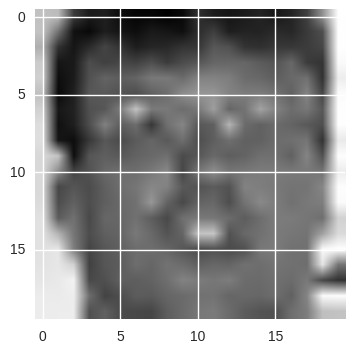

In [11]:
plt.imshow(faces[1000].reshape((20, 20)), cmap=plt.cm.gray)

In [12]:
from sklearn.neighbors import NearestNeighbors

In [13]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=100, algorithm='brute').fit(faces)

In [15]:
%time result = knn.kneighbors(faces[1000].reshape((1, -1)))

CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 35.7 ms


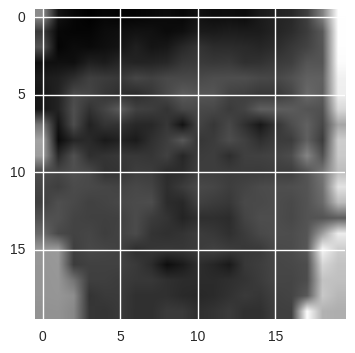

In [16]:
plt.imshow(faces[267].reshape((20, 20)), cmap=plt.cm.gray)